In [ ]:
import io
from google.colab import files
uploaded1 = files.upload() # Upload HappinessCantrilLadder2005-2020.csv from local drive
uploaded2 = files.upload() # Upload numOfInternetUsers.csv from local drive

Saving HappinessCantrilLadder2005-2020.csv to HappinessCantrilLadder2005-2020.csv


Saving numOfInternetUsers.csv to numOfInternetUsers.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

## Setup: Import the Datasets
Dataset on Happiness Index: Attached file <mark>"HappinessCantrilLadder2005-2020.csv"</mark><br/>
Dataset on Internet Users: Attached file <mark>"numOfInternetUsers.csv"</mark>.

In [ ]:
happiness_index_df = pd.read_csv(io.BytesIO(uploaded1['HappinessCantrilLadder2005-2020.csv']))
happiness_index_df.rename(columns = {'Life satisfaction in Cantril Ladder (World Happiness Report 2021)' : 'Ladder Score'}, inplace = True)
happiness_index_df.head()


,Entity,Code,Year,Ladder Score
0,Afghanistan,AFG,2008,3.724
1,Afghanistan,AFG,2009,4.402
2,Afghanistan,AFG,2010,4.758
3,Afghanistan,AFG,2011,3.832
4,Afghanistan,AFG,2012,3.783


In [ ]:
happiness_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Entity        1949 non-null   object 
 1   Code          1945 non-null   object 
 2   Year          1949 non-null   int64  
 3   Ladder Score  1949 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 61.0+ KB


In [ ]:
internet_df = pd.read_csv(io.BytesIO(uploaded2['numOfInternetUsers.csv']))
internet_df = internet_df.drop(["Indicator Name", "Indicator Code"], axis=1)
internet_df.rename(columns = {'Country Code' : 'Code'}, inplace = True)

internet_df = internet_df.melt(["Country Name", "Code"])
internet_df.rename(columns = {'variable' : 'Year', 'value' : 'Internet Users Percentage'}, inplace = True)

internet_df['Year']=internet_df['Year'].astype(int)
internet_df.head()

,Country Name,Code,Year,Internet Users Percentage
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,NaN
2,Afghanistan,AFG,1960,NaN
3,Africa Western and Central,AFW,1960,NaN
4,Angola,AGO,1960,NaN


In [ ]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16226 entries, 0 to 16225
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country Name               16226 non-null  object 
 1   Code                       16226 non-null  object 
 2   Year                       16226 non-null  int64  
 3   Internet Users Percentage  7436 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 507.2+ KB


# Exploratory Data Analysis
Create a new empty dataframe with columns <mark>"Ladder Score"and "Internet Users Percentage"</mark> and append the relevant columns from the 2 imported datasets into the new dataframe on the condition that the country is present in both datasets.<br/>

In [ ]:
concat_df = pd.merge(happiness_index_df, internet_df, on=["Year", 'Code'], how='left')
concat_df = concat_df.drop(["Entity", "Code", "Year", "Country Name"], axis=1)
concat_df.dropna(inplace= True)


concat_df.reset_index(drop = True, inplace=True)
concat_df


,Ladder Score,Internet Users Percentage
0,3.724,1.840000
1,4.402,3.550000
2,4.758,4.000000
3,3.832,5.000000
4,3.783,5.454545
...,...,...
1763,3.703,22.742818
1764,3.735,23.119989
1765,3.638,24.400000
1766,3.616,25.000000


In [ ]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ladder Score               1768 non-null   float64
 1   Internet Users Percentage  1768 non-null   float64
dtypes: float64(2)
memory usage: 27.8 KB


<mark>Anomaly Detection</mark> Using <mark>Isolation Forest</mark>

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
# Estimation of the anomaly population of the dataset (necessary for IsolationForest)
contamination = 0.01
# Copy concat_df into a temporary dataframe
df = concat_df.copy()
# Remove the country column in order to use IsolationForest
# del df["Country"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ladder Score               1768 non-null   float64
 1   Internet Users Percentage  1768 non-null   float64
dtypes: float64(2)
memory usage: 27.8 KB


In [ ]:
# Model Training
model = IsolationForest(contamination = contamination)
model.fit(df)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.01)

In [ ]:
# Prediction
df["Anomalies_scores"] = model.decision_function(df[["Ladder Score", "Internet Users Percentage"]])
df["Anomaly"] = model.predict(df[["Ladder Score", "Internet Users Percentage"]])
df.head()

,Ladder Score,Internet Users Percentage,Anomalies_scores,Anomaly
0,3.724,1.840000,0.110754,1
1,4.402,3.550000,0.137788,1
2,4.758,4.000000,0.135240,1
3,3.832,5.000000,0.132353,1
4,3.783,5.454545,0.126351,1


In [ ]:
concat_df["Anomaly"] = df["Anomaly"]
concat_df.head(2000)
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ladder Score               1768 non-null   float64
 1   Internet Users Percentage  1768 non-null   float64
 2   Anomaly                    1768 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 41.6 KB


In [ ]:
# Removing the Anomalies
concat_df = concat_df[concat_df.Anomaly == 1]
concat_df.reset_index(drop = True, inplace=True)
#concat_df.head()
del concat_df["Anomaly"]
#concat_df.head()
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ladder Score               1750 non-null   float64
 1   Internet Users Percentage  1750 non-null   float64
dtypes: float64(2)
memory usage: 27.5 KB


Explore the response variable <mark>"Ladder Score"</mark>.

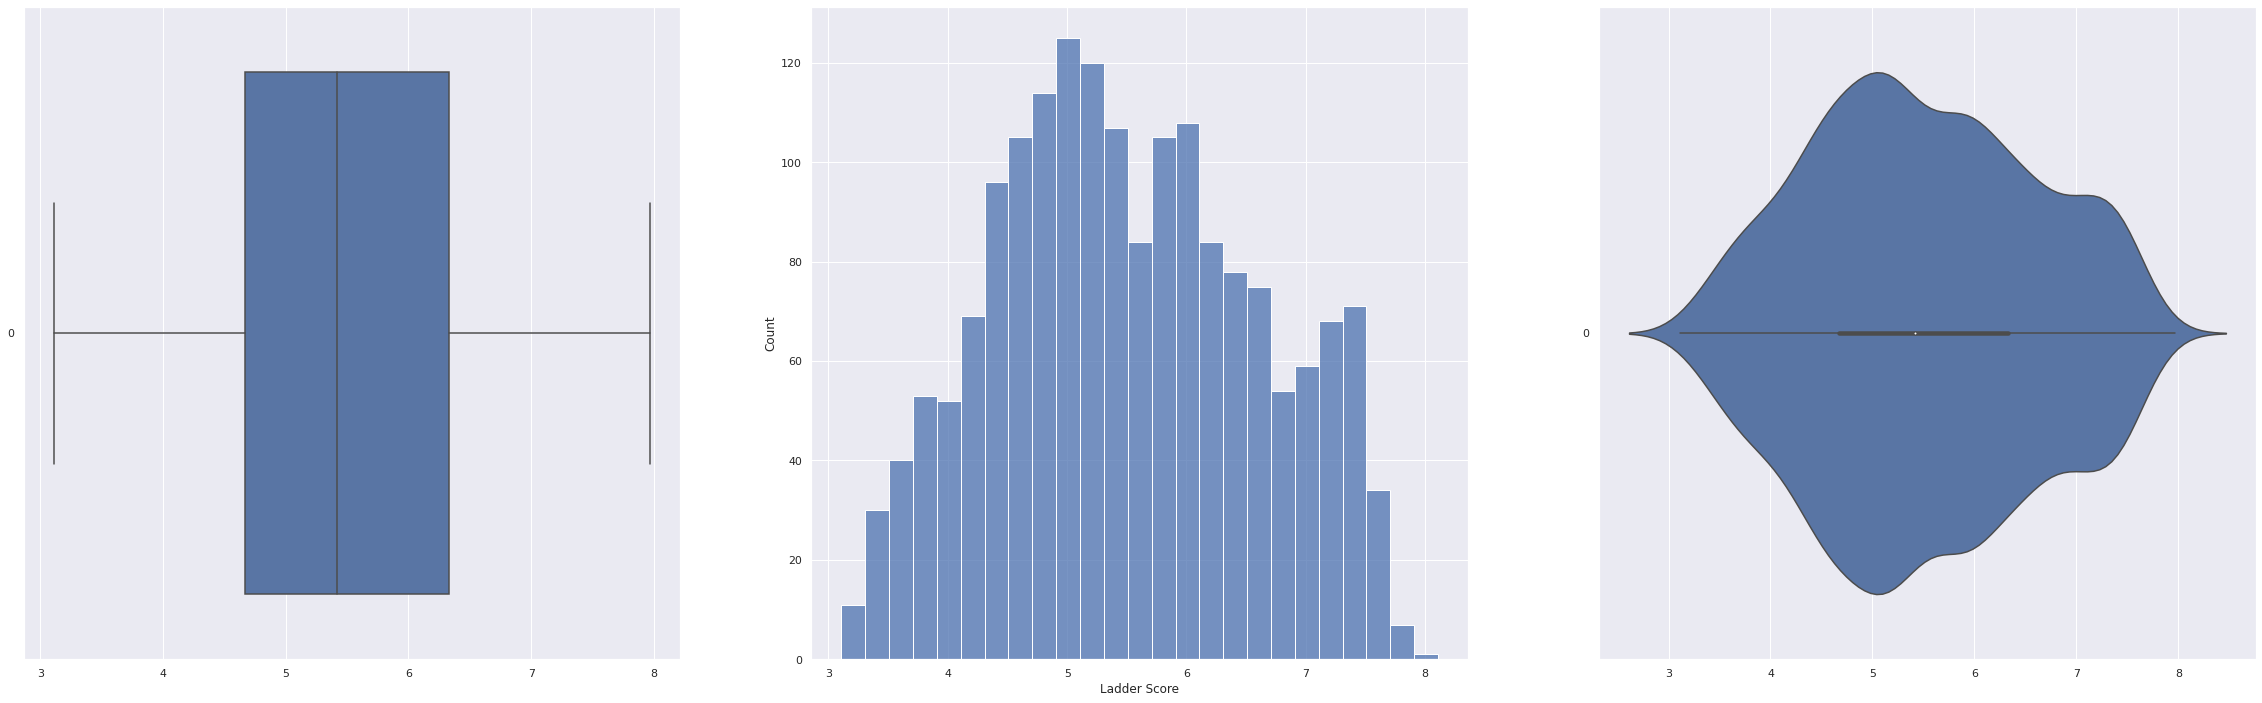

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = concat_df["Ladder Score"], orient = "h", ax = axes[0])
sb.histplot(data = concat_df['Ladder Score'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = concat_df["Ladder Score"], orient = "h", ax = axes[2])

Explore the predictor variable <mark>"Internet Users Percentage"</mark>.

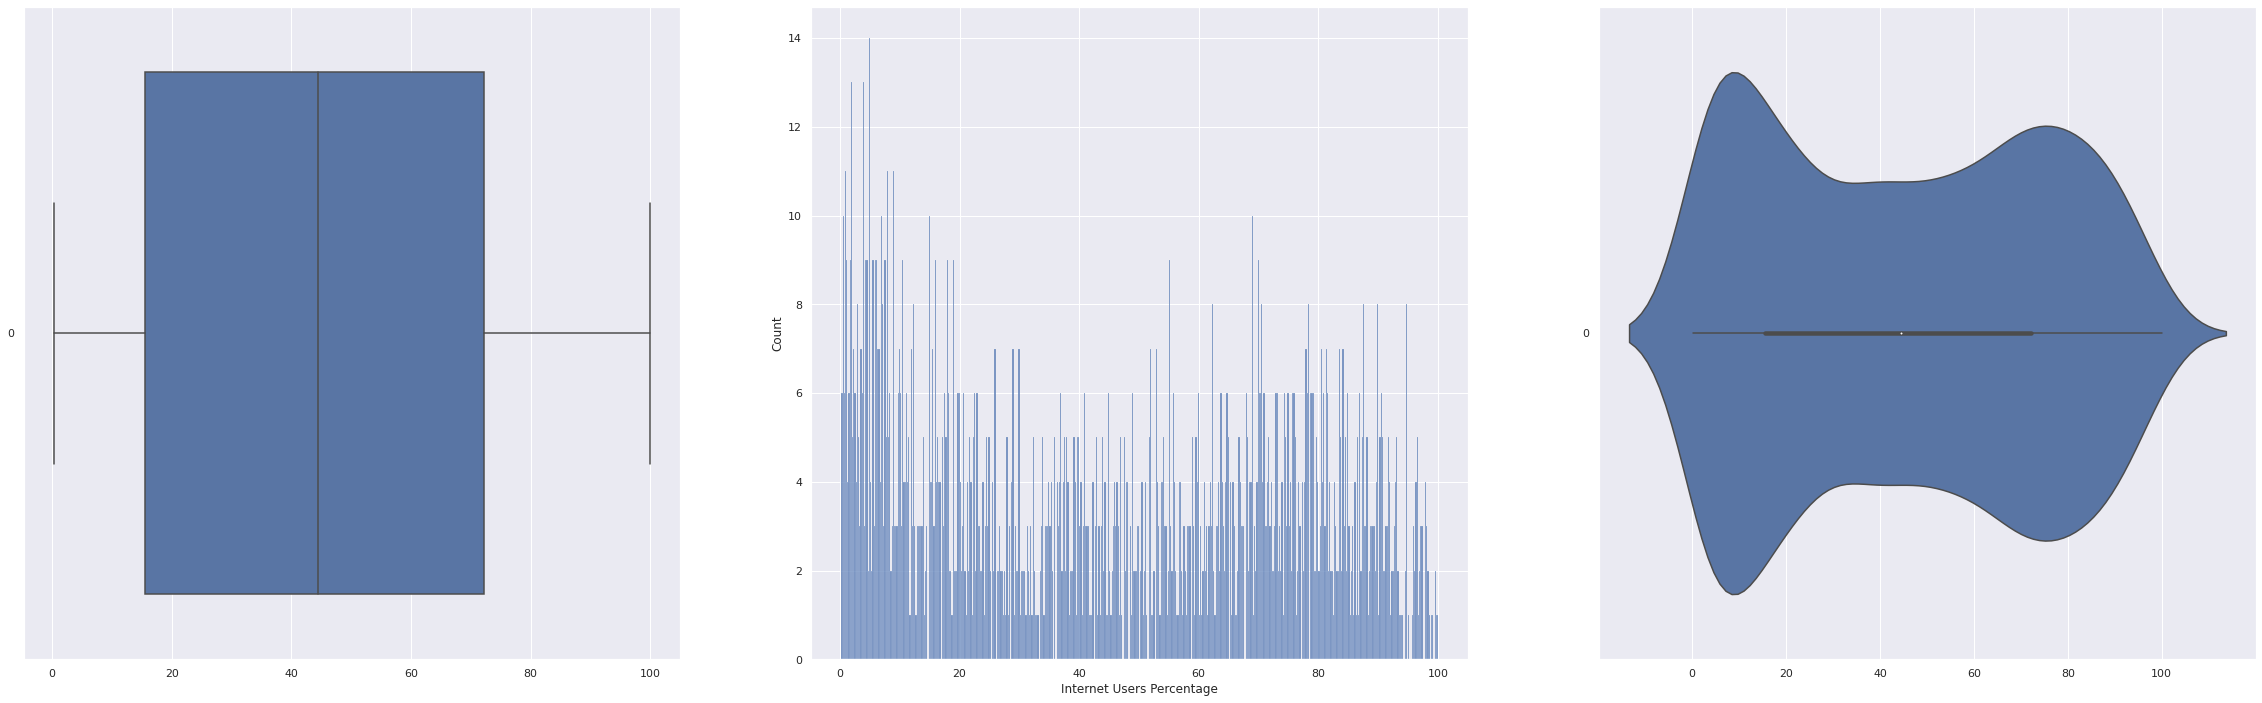

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = concat_df["Internet Users Percentage"], orient = "h", ax = axes[0])
sb.histplot(data = concat_df['Internet Users Percentage'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = concat_df["Internet Users Percentage"], orient = "h", ax = axes[2])

Find rows that are <mark>outliers</mark> for <mark>"Ladder Score"</mark> and <mark>"Internet Users Percentage"</mark> and remove them.

In [ ]:
HappinessIndex_q3, HappinessIndex_q1 = np.percentile(concat_df["Ladder Score"], [75, 25])
InternetUsersPercentage_q3, InternetUsersPercentage_q1 = np.percentile(concat_df["Internet Users Percentage"], [75, 25])
HappinessIndex_iqr = HappinessIndex_q3 - HappinessIndex_q1
InternetUsersPercentage_iqr = InternetUsersPercentage_q3 - InternetUsersPercentage_q1
deleteRow = False
index_to_remove = []
for index, row in concat_df.iterrows():
    deleteRow = False
    if (row["Ladder Score"] <= HappinessIndex_q1 - 1.5*HappinessIndex_iqr) or (row["Ladder Score"] >= HappinessIndex_q3 + 1.5*HappinessIndex_iqr):
        deleteRow = True
    if (row["Internet Users Percentage"] <= InternetUsersPercentage_q1 - 1.5*InternetUsersPercentage_iqr) or (row["Internet Users Percentage"] >= InternetUsersPercentage_q3 + 1.5*InternetUsersPercentage_iqr):
        deleteRow = True
    if deleteRow == True:
        index_to_remove.append(index)
for index in index_to_remove:
    concat_df.drop(index = index, inplace = True)




Explore the response variable <mark>"Ladder Score"</mark>.

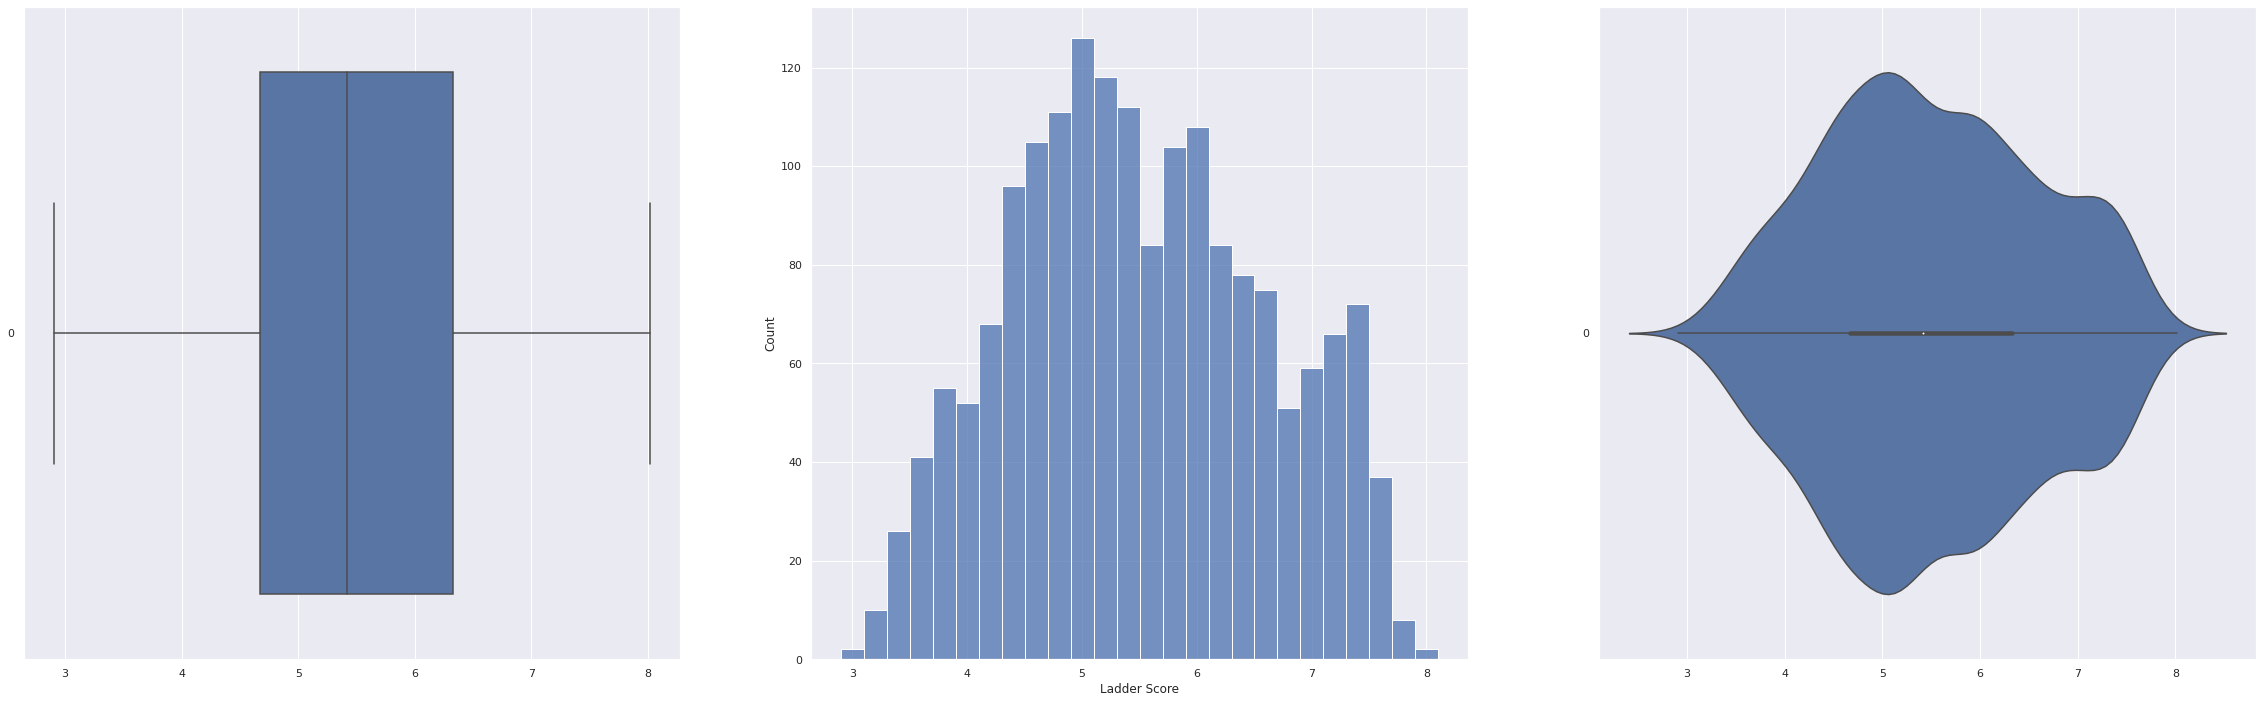

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = concat_df["Ladder Score"], orient = "h", ax = axes[0])
sb.histplot(data = concat_df['Ladder Score'], ax = axes[1], binwidth = 0.2)
sb.violinplot(data = concat_df["Ladder Score"], orient = "h", ax = axes[2])

Explore the predictor variable <mark>"InternetUsersPercentage"</mark>.

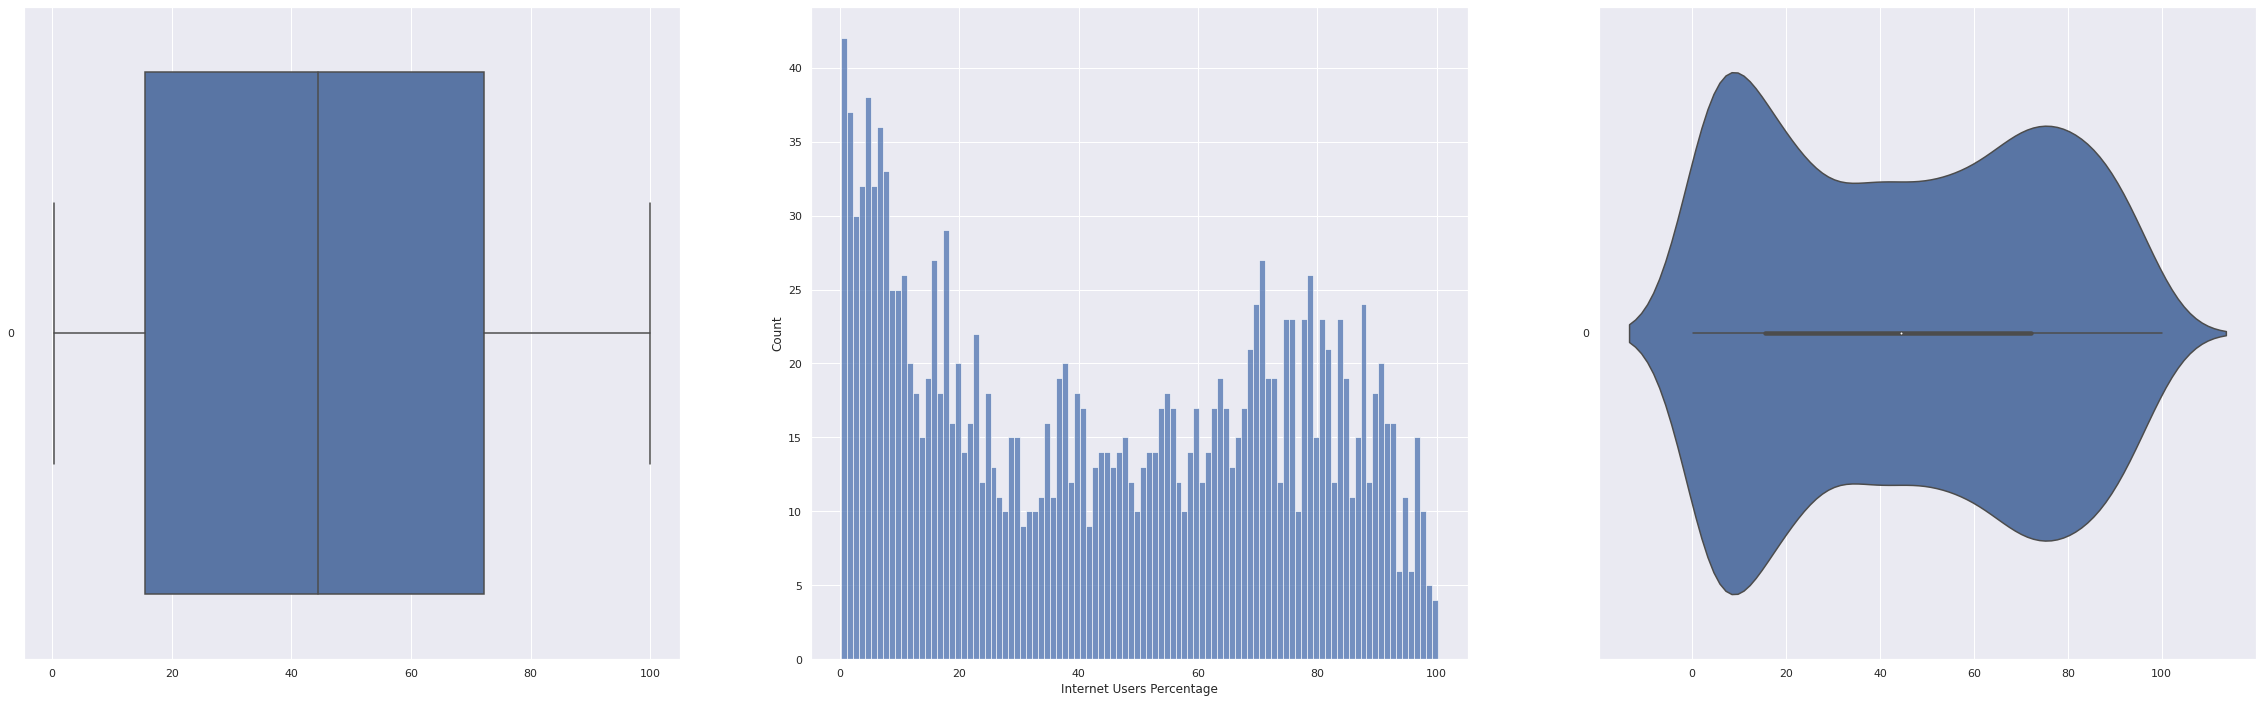

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(40, 12))
sb.boxplot(data = concat_df["Internet Users Percentage"], orient = "h", ax = axes[0])
sb.histplot(data = concat_df['Internet Users Percentage'], ax = axes[1], binwidth = 1)
sb.violinplot(data = concat_df["Internet Users Percentage"], orient = "h", ax = axes[2])

Joinplot of <mark>"HappinessIndex"</mark> against <mark>"InternetUsersPercentage"</mark>

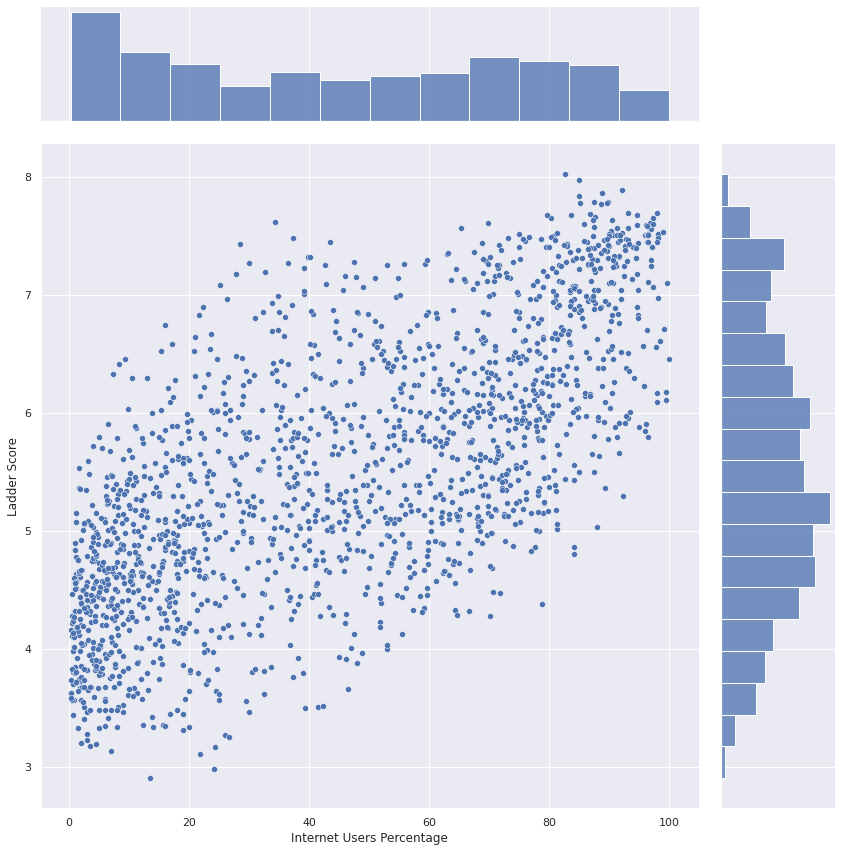

In [ ]:
sb.jointplot(data = concat_df, x = "Internet Users Percentage", y = "Ladder Score", height = 12)

Calculate the <mark>correlation</mark> between the two variables




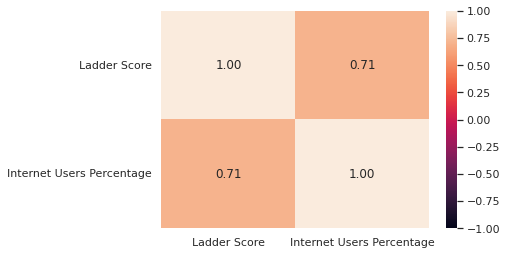

In [ ]:
# Calculate the correlation between the two columns/variables
sb.heatmap(concat_df.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

<mark>Linear regression</mark> would be a suitable method for machine learning since there is a relatively <mark>high corrleation</mark> between the two variables

# Machine Learning Using Linear Regression

Response Variable : Ladder Score
Predictor Feature : Internet Users Percentage

> Regression Model : Ladder Score = $a$ $\times$ Internet Users Percentage + $b$  

Split the Train and Test Sets randomly and perform Linear Regression

Train Set : (1400, 1) (1400, 1)
Test Set  : (350, 1) (350, 1)
Intercept of Regression 	: b =  [-61.20292995]
Coefficients of Regression 	: a =  [[19.34333216]]



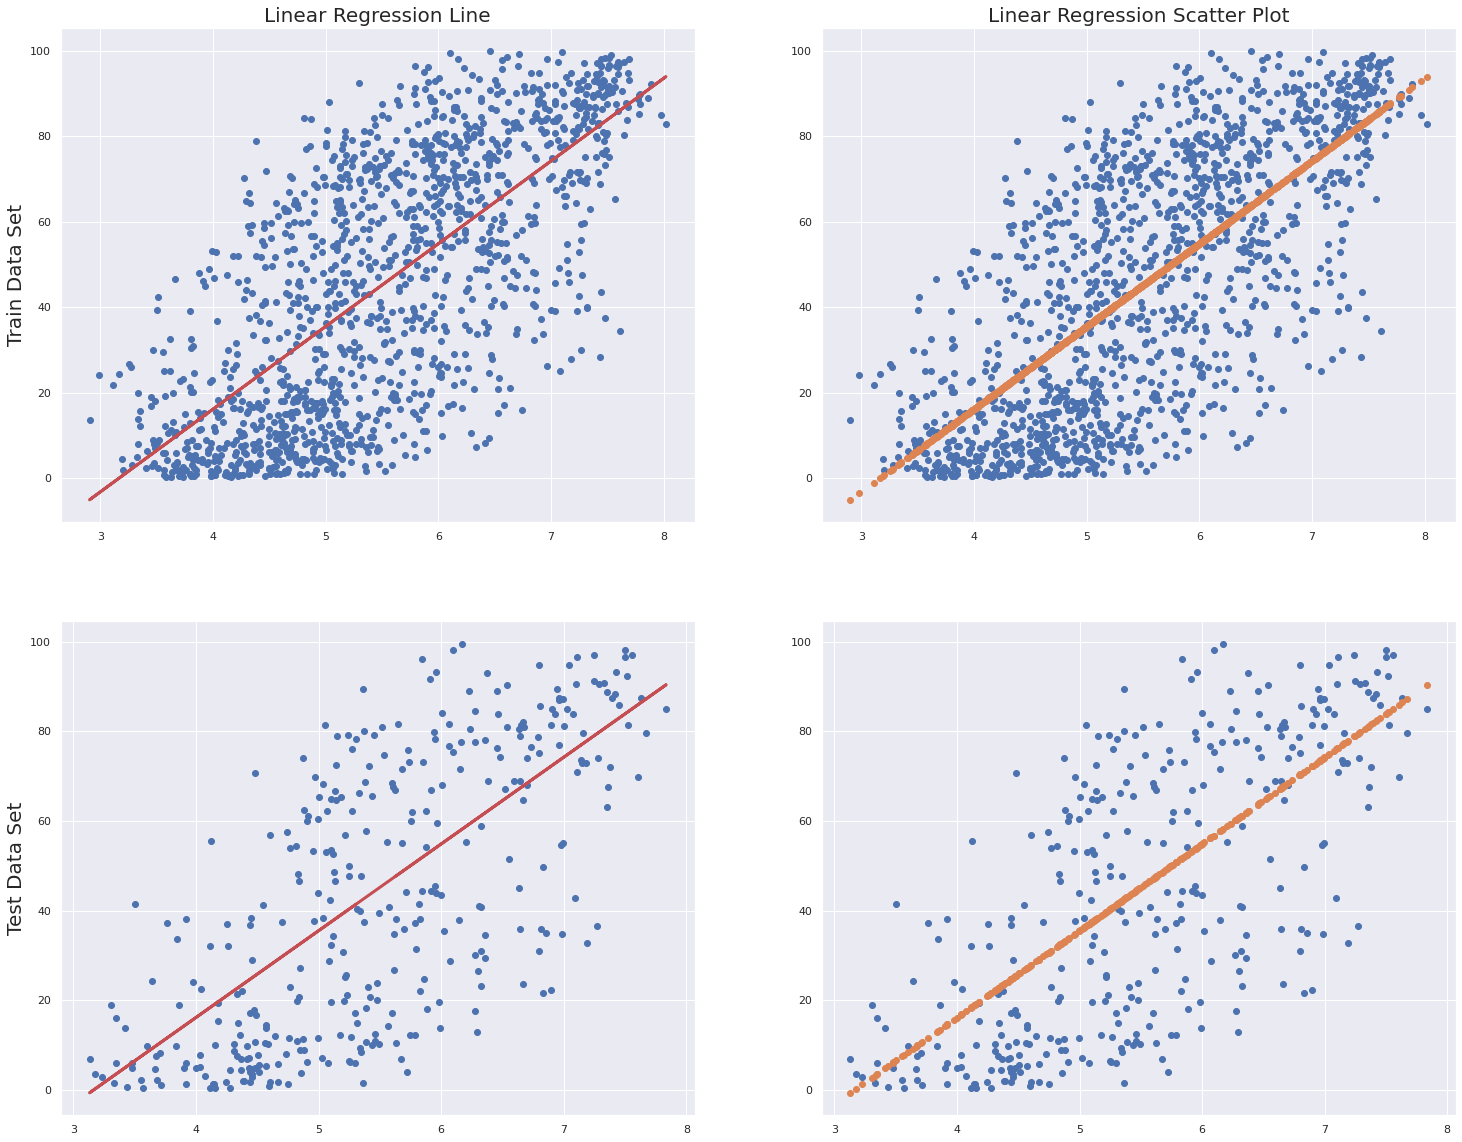

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5016302374262338
Mean Squared Error (MSE) 	: 456.516289247778
Root Mean Squared Error (RMSE) 	: 21.366241813846862

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.4855881537973298
Mean Squared Error (MSE) 	: 483.25837481388373
Root Mean Squared Error (RMSE) 	: 21.983138420477722


The higher the variance, the 'less good' the fit is.
The lower the MSE, the more accurate the model is.


In [ ]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

traindf = concat_df.dropna()
gla = pd.DataFrame(traindf['Ladder Score']) 
sp = pd.DataFrame(traindf['Internet Users Percentage']) 
sp.head()

X_train, X_test, y_train, y_test = train_test_split(gla, sp, test_size = 0.2, shuffle = True)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model




# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Assign X-train data into regine_x
regline_x = X_train

# FOR TRAINED DATA SET
# !! For LINE GRAPH
regline_y = linreg.coef_ * X_train + linreg.intercept_
f, axes = plt.subplots(2, 2, figsize=(25, 20))
axes[0,0].scatter(X_train, y_train)
axes[0,0].plot(regline_x, regline_y, 'r-', linewidth = 3)
axes[0,0].set_title("Linear Regression Line", fontsize=20)
axes[0,0].set_ylabel("Train Data Set", fontsize=20)

# !! For PREDICTED SCATTER LINE
y_train_pred = linreg.predict(X_train)
axes[0,1].scatter(X_train, y_train)
axes[0,1].scatter(X_train, y_train_pred)
axes[0,1].set_title("Linear Regression Scatter Plot", fontsize=20)

## FOR TEST DATA SET
regline_xtest = X_test
y_test_pred = linreg.predict(X_test)

axes[1,0].scatter(X_test, y_test)
axes[1,0].plot(regline_xtest, y_test_pred, 'r-', linewidth = 3)
axes[1,0].set_ylabel("Test Data Set", fontsize=20)

axes[1,1].scatter(X_test, y_test)
axes[1,1].scatter(regline_xtest, y_test_pred)
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:", mean_squared_error(y_train, y_train_pred, squared = False))

print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", mean_squared_error(y_test, y_test_pred, squared = False))

print()

print("""
The higher the variance, the 'less good' the fit is.
The lower the MSE, the more accurate the model is.""")


GoodnessTrain1 = linreg.score(X_train, y_train)
AccuracyTrain1 = mean_squared_error(y_train, y_train_pred, squared = False)
GoodnessTest1 = linreg.score(X_test, y_test)
AccuracyTest1 = mean_squared_error(y_test, y_test_pred, squared = False)